In [ ]:
import importlib
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import healpix_utils

In [ ]:
importlib.reload(healpix_utils)

In [ ]:
cat_hk25 = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['EU']
cat_nextgems = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")["ICON"]

In [ ]:
print(list(cat_hk25))

In [ ]:
print(list(cat_nextgems))

# Global variables

In [ ]:
zoom = 4 # # https://easy.gems.dkrz.de/Processing/healpix/index.html 
deg = 1 # degree for regridded cell
idx = healpix_utils.get_nn_lon_lat_index(
    2**zoom, np.linspace(0+deg/2, 360-deg/2, int(360/deg)), 
    np.linspace(-90+deg/2, 90-deg/2, int(180/deg))
)

# ICON 

In [ ]:
icon_simulations = {"ngc3028": {"long_name": "ICON cyc3"}, 
                    "icon_ngc4008": {"long_name": "ICON cyc4"},
              "icon_d3hp003": {"long_name": "ICON cyc5"}}

In [ ]:
pd.DataFrame(cat_hk25["icon_d3hp003"].describe()["user_parameters"])

In [ ]:
interesting_variables = ["tas", "prw", 
                         "clivi", "cllvi", 'clwvi', "pr",
                         "rsdt",  "rsut",  "rlut"] 

In [10]:
for simu_name in list(icon_simulations.keys()): 
    if simu_name == "ngc3028": 
        cat = cat_nextgems 
    else: 
        cat = cat_hk25
    icon = cat[simu_name](zoom=zoom).to_dask()
    
    icon = icon[[v for v in interesting_variables if v in list(icon.data_vars)]]
    if 'clwvi' in icon.data_vars:
        icon = icon.rename({'clwvi': 'cllvi'})
    icon["pr"] = (icon.pr*3600*24/1000*1000) # conversion to mm 
    icon = icon.sel(time=slice("2020-03-01", "2031-01-01")) # remove 1st 2 month spin-up 
    icon_toa = icon.isel(cell=idx).mean(["lon", "time"])
    icon_simulations[simu_name]['lat_profile'] = icon_toa

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


# ERA5

In [11]:
pd.DataFrame(cat_hk25["ERA5"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[8, 7, 6, 5, 4, 3, 2, 1, 0]",7


In [12]:
era5 = cat_hk25['ERA5'](zoom=zoom).to_dask()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [13]:
interesting_variables = ["2t", "tcwv", 
                         "tcc",  "tciw", "tclw", 'tp',
                         "tisr", "tsr", "tsrc", "ttr", 'ttrc'] 

In [14]:
era5 = era5[interesting_variables]
era5['tsr'] = era5.tisr - era5.tsr
era5 = era5.rename({'tsr': 'rsut',
                    'ttr': 'rlut', 
                    'tisr': 'rsdt',
                   '2t': 'tas', 
                   'tcwv': 'prw', 
                   'tciw': 'clivi', 
                   'tclw': 'cllvi', 
                    'tp': 'pr'
                   })

In [15]:
era5 = era5.sel(time=slice("2003-01-01", "2024-01-1"))

In [16]:
era5_toa = era5.drop_vars(["lat", "lon"]).isel(cell=idx).mean(["lon", "time"])
era5_toa['rlut'] = - era5_toa.rlut / (3600*24) # to convert to W m-2
era5_toa['rsut'] = era5_toa.rsut / (3600*24) # to convert to W m-2
era5_toa['pr'] = era5_toa.pr * 1000 # to convert to mm

In [17]:
interesting_variables = ["2t", "tcwv", "tcc", "tciw", "tclw",
                         
                         "tisr", "tsr", "tsrc", "ttr", 'ttrc'] 

In [18]:
era5 = era5[interesting_variables]
era5['tsr'] = era5.tisr - era5.tsr
era5 = era5.rename({'tsr': 'rsut',
                    'ttr': 'rlut', 
                    'tciw': 'clivi', 
                    'tclw': 'cllvi', 
                    'tcwv': 'prw'})

In [19]:
era5 = era5.sel(time=slice("2003-01-01", "2024-01-1"))

In [20]:
era5_toa = era5.drop_vars(["lat", "lon"]).isel(cell=idx).mean(["lon", "time"])
era5_toa['rlut'] = - era5_toa.rlut / (3600*24) # to convert to W m-2
era5_toa['rsut'] = era5_toa.rsut / (3600*24) # to convert to W m-2

# CERES

In [26]:
ddir_ceres = '/pool/data/ICDC/atmosphere/ceres_ebaf/DATA/' # on Levante

In [27]:
ceres = xr.open_dataset(ddir_ceres + "CERES_EBAF-TOA_Edition4.2_ZONALMEAN_MONTHLY_CLIMATOLOGY.nc")

In [28]:
ceres = ceres[[
    "ztoa_sw_all_clim", "ztoa_lw_all_clim"]
].mean('ctime').rename(
    {"ztoa_sw_all_clim":"rsut", "ztoa_lw_all_clim": "rlut"})

# Compare

In [17]:
from matplotlib import colormaps

In [18]:
cmap = colormaps["Set2"]

In [23]:
v_dict = {'rlut': 'Outgoing Longwave Radiation\nOLR [W m$^{-2}$]', 
         'rsut': 'Reflected Shortwave Radiation\nRSW [W m$^{-2}$]', 
         'cllvi': 'LWP [kg m$^{-2}$]', 
         'clivi': 'IWP [kg m$^{-2}$]', 
         'pr': 'Surface Precipitation [mm]',
         'prw': 'Precipitable Water [mm]'}

In [38]:
def plot_lat_profiles(list_variables, plot_title, plot_ceres=False): 
    f,axes = plt.subplots(int(len(list_variables)//2),2, figsize=(13,len(list_variables)//2*4))
    axes = axes.flatten() 
    
    for v_id,v in enumerate(list_variables): 
        ax = axes[v_id] 
        for i,simu_name in enumerate(list(icon_simulations.keys())):
            icon_simulations[simu_name]['lat_profile'][v].plot(ax=ax, lw=3, c=cmap(i), label=icon_simulations[simu_name]['long_name'])
    
        if plot_ceres: 
            ceres[v].plot(ax=ax, lw=4, c='black', label='CERES',zorder = 1)
        era5_toa[v].plot(ax=ax, lw=5, ls=":", c='grey', label='ERA5')
        ax.set_ylabel(v_dict[v], fontsize=11);
        ax.set_title('')
        ax.set_xlabel(r"Latitude [$^{\circ}$]", fontsize=11)
    ax.legend()
    f.suptitle(plot_title);

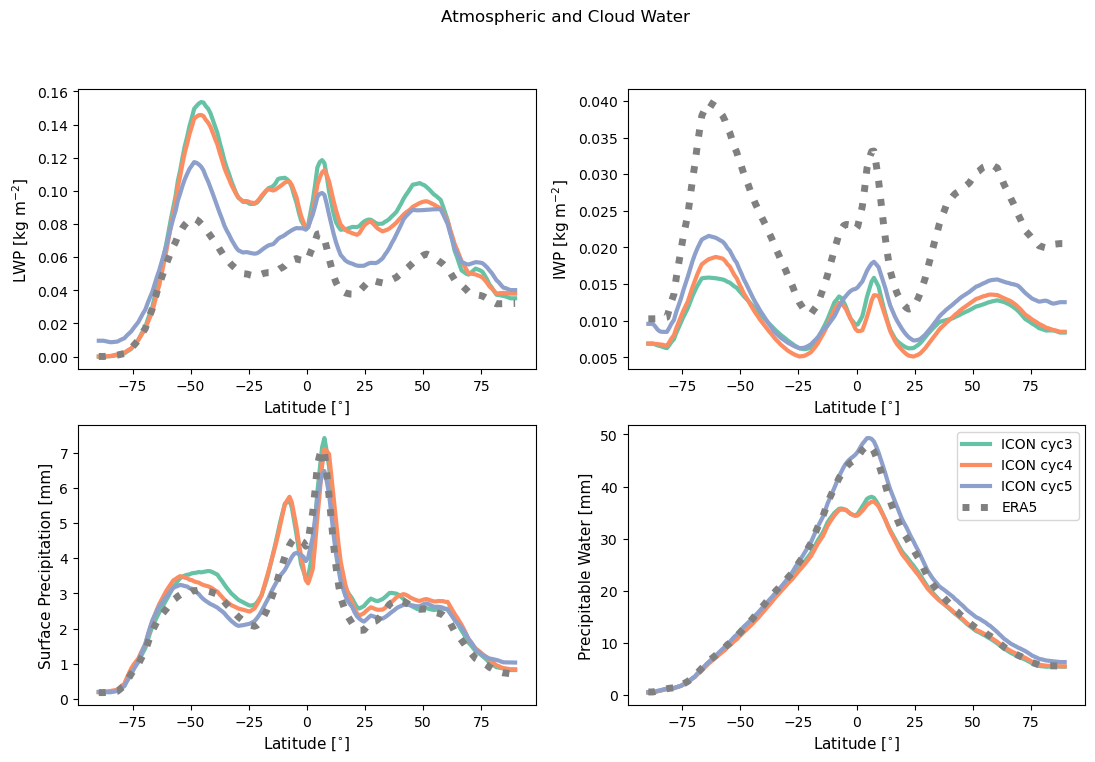

In [39]:
plot_lat_profiles(['cllvi', 'clivi', 'pr', 'prw'], 'Atmospheric and Cloud Water')

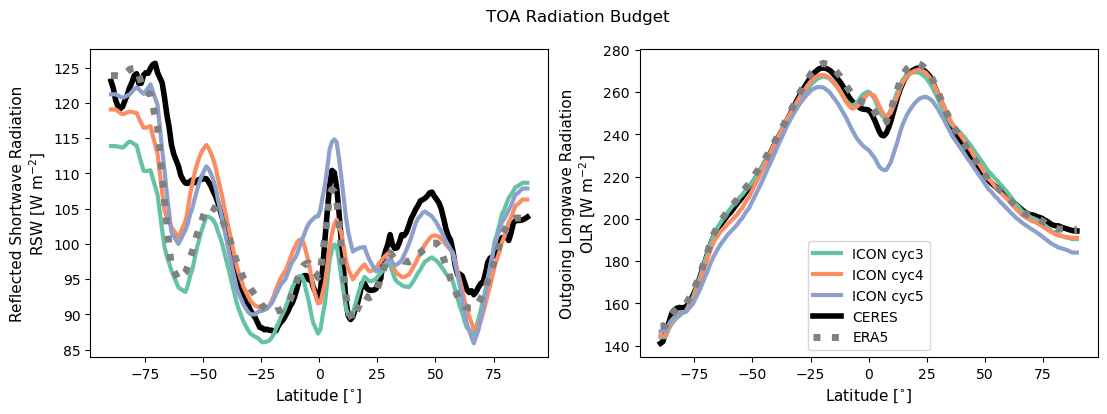

In [41]:
plot_lat_profiles(['rsut', 'rlut'], 'TOA Radiation Budget', plot_ceres=True)